In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1 import AxesGrid
import pandas as pd
import xarray as xr
import copy
import datetime as dt
import calendar
import seaborn as sns
import regionmask
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib as mpl

In [2]:
def covariance(x,y,dim=None):
    return xr.dot(x-x.mean(dim), y-y.mean(dim), dims=dim) / x.count(dim)


def correlation(x,y,dim=None):
    return covariance(x,y,dim) / (x.std(dim) * y.std(dim))

def xr_trends(xarray):
    """ Calcula la tendencia
    lineal de un xarray en el tiempo"""
    vals = xarray.values
    years = xarray.time.dt.year.values
    # Reshape to an array with as many rows as years and as many columns as there are pixels
    vals2 = vals.reshape(len(years), -1)
    # Do a first-degree polyfit
    regressions = np.polyfit(years, vals2, 1)
    # Get the coefficients back
    trends = regressions[0,:].reshape(vals.shape[1], vals.shape[2])
    da_trends = xr.DataArray(trends, coords={'lat': xarray.lat,
                                             'lon': xarray.lon},
                            dims=['lat', 'lon'])
    return da_trends

def rolling_sub(xarray):
    """ Calcula la resta fecha a fecha
     y la asigna a la fecha posterior"""
    prev = xarray.isel(time=slice(0, len(xarray.time) - 1))
    post = xarray.isel(time=slice(1, len(xarray.time)))
    subs_vals = post.values - prev.values
    substraction = xr.DataArray(subs_vals, coords={'lat': xarray.lat,
                                                   'lon': xarray.lon,
                                                   'time': post.time},
                                dims=['time', 'lat', 'lon'])
    return substraction
    

In [84]:
# Load observational
sm_thin_obs = xr.open_dataset('observacionales/GLDAS_2.5.nc')['SoilMoi0_10cm_inst'].isel(time=slice(12,372))
pr_obs = xr.open_dataset('observacionales/precip.mon.total.v7_197601-200512_2.5_anu.nc')['precip']
tmp_obs = xr.open_dataset('observacionales/tmp_cru_ts3.20_197601-200512_2.5_anu.nc')['tmp']
sm_thin_obs = sm_thin_obs.assign_coords({"lon": (sm_thin_obs.lon % 360)})

In [4]:
# Load files CMIP5

pr_c5_hist = xr.open_mfdataset('NorESM1-M/pr_Amon_NorESM1-M_historical_r*i1p1_197601-200512_2.5_anu.nc',
                              combine='nested',
                              concat_dim='r')['pr']
pr_c5_ens = pr_c5_hist.mean(dim='r', keep_attrs=True)
pr_c5_26_close = xr.open_dataset('NorESM1-M/pr_Amon_NorESM1-M_rcp26_r1i1p1_202001-204912_2.5_anu.nc'
                                )['pr']
pr_c5_26_far = xr.open_dataset('NorESM1-M/pr_Amon_NorESM1-M_rcp26_r1i1p1_207001-209912_2.5_anu.nc'
                                )['pr']
pr_c5_85_close = xr.open_dataset('NorESM1-M/pr_Amon_NorESM1-M_rcp85_r1i1p1_202001-204912_2.5_anu.nc'
                                )['pr']
pr_c5_85_far = xr.open_dataset('NorESM1-M/pr_Amon_NorESM1-M_rcp85_r1i1p1_207001-209912_2.5_anu.nc'
                                )['pr']

# """"""""""""""""""""""""""""""""""""""""""
ev_c5_hist = xr.open_mfdataset('NorESM1-M/evspsbl_Amon_NorESM1-M_historical_r*i1p1_197601-200512_2.5_anu.nc',
                               combine='nested',
                               concat_dim='r')['evspsbl']
ev_c5_ens = ev_c5_hist.mean(dim='r', keep_attrs=True)
ev_c5_26_close = xr.open_dataset('NorESM1-M/evspsbl_Amon_NorESM1-M_rcp26_r1i1p1_202001-204912_2.5_anu.nc'
                                )['evspsbl']
ev_c5_26_far   = xr.open_dataset('NorESM1-M/evspsbl_Amon_NorESM1-M_rcp26_r1i1p1_207001-209912_2.5_anu.nc'
                                )['evspsbl']
ev_c5_85_close = xr.open_dataset('NorESM1-M/evspsbl_Amon_NorESM1-M_rcp85_r1i1p1_202001-204912_2.5_anu.nc'
                                )['evspsbl']
ev_c5_85_far   = xr.open_dataset('NorESM1-M/evspsbl_Amon_NorESM1-M_rcp85_r1i1p1_207001-209912_2.5_anu.nc'
                                )['evspsbl']
# """"""""""""""""""""""""""""""""""""""""""
ep_c5_hist = xr.open_mfdataset('NorESM1-M/etp_Amon_NorESM1-M_historical_r*i1p1_197601-200512_2.5_anu.nc',
                               combine='nested',
                               concat_dim='r')['etp']
ep_c5_ens = ep_c5_hist.mean(dim='r', keep_attrs=True)
ep_c5_26_close = xr.open_dataset('NorESM1-M/etp_Amon_NorESM1-M_rcp26_r1i1p1_202001-204912_2.5_anu.nc'
                                )['etp']
ep_c5_26_far   = xr.open_dataset('NorESM1-M/etp_Amon_NorESM1-M_rcp26_r1i1p1_207001-209912_2.5_anu.nc'
                                )['etp']
ep_c5_85_close = xr.open_dataset('NorESM1-M/etp_Amon_NorESM1-M_rcp85_r1i1p1_202001-204912_2.5_anu.nc'
                                )['etp']
ep_c5_85_far   = xr.open_dataset('NorESM1-M/etp_Amon_NorESM1-M_rcp85_r1i1p1_207001-209912_2.5_anu.nc'
                                )['etp']
# """"""""""""""""""""""""""""""""""""""""""""

t_c5_hist = xr.open_mfdataset('NorESM1-M/tas_Amon_NorESM1-M_historical_r*i1p1_197601-200512_2.5_anu.nc',
                              combine='nested',
                              concat_dim='r')['tas']
t_c5_ens = t_c5_hist.mean(dim='r', keep_attrs=True)
t_c5_26_close = xr.open_dataset('NorESM1-M/tas_Amon_NorESM1-M_rcp26_r1i1p1_202001-204912_2.5_anu.nc'
                               )['tas']
t_c5_26_far   = xr.open_dataset('NorESM1-M/tas_Amon_NorESM1-M_rcp26_r1i1p1_207001-209912_2.5_anu.nc'
                               )['tas']
t_c5_85_close = xr.open_dataset('NorESM1-M/tas_Amon_NorESM1-M_rcp85_r1i1p1_202001-204912_2.5_anu.nc'
                               )['tas']
t_c5_85_far   = xr.open_dataset('NorESM1-M/tas_Amon_NorESM1-M_rcp85_r1i1p1_207001-209912_2.5_anu.nc'
                               )['tas']
# """"""""""""""""""""""""""""""""""""""
q_c5_hist = xr.open_mfdataset('NorESM1-M/huss_historical_r*_anu.nc',
                            combine='nested',
                            concat_dim='r')['huss']
q_c5_ens = q_c5_hist.mean(dim='r', keep_attrs=True)
q_c5_26_close = xr.open_dataset('NorESM1-M/huss_Amon_NorESM1-M_rcp26_r1_202001-204912_2.5_anu.nc'
                               )['huss']
q_c5_26_far   = xr.open_dataset('NorESM1-M/huss_Amon_NorESM1-M_rcp26_r1_207001-209912_2.5_anu.nc'
                               )['huss']
q_c5_85_close = xr.open_dataset('NorESM1-M/huss_Amon_NorESM1-M_rcp85_r1_202001-204912_2.5_anu.nc'
                               )['huss']
q_c5_85_far   = xr.open_dataset('NorESM1-M/huss_Amon_NorESM1-M_rcp85_r1_207001-209912_2.5_anu.nc'
                               )['huss']
# """"""""""""""""""""""""""""""""""""""

sm_c5_hist = xr.open_mfdataset('NorESM1-M/mrsos_Lmon_NorESM1-M_historical_r*_2.5.nc',
                               combine='nested',
                               concat_dim='r')['mrsos']
sm_c5_ens = sm_c5_hist.mean(dim='r', keep_attrs=True)
sm_c5_26_close = xr.open_dataset('NorESM1-M/mrsos_Lmon_NorESM1-M_rcp26_r1_2020-2049_2.5.nc')['mrsos']
sm_c5_26_far   = xr.open_dataset('NorESM1-M/mrsos_Lmon_NorESM1-M_rcp26_r1_2070-2099_2.5.nc')['mrsos']
sm_c5_85_close = xr.open_dataset('NorESM1-M/mrsos_Lmon_NorESM1-M_rcp85_r1_2020-2049_2.5.nc')['mrsos']
sm_c5_85_far   = xr.open_dataset('NorESM1-M/mrsos_Lmon_NorESM1-M_rcp85_r1_2070-2099_2.5.nc')['mrsos']

In [5]:
# Load files CMIP6
pr_c6_hist = xr.open_mfdataset('NorESM2-LM/pr_Amon_NorESM2-LM_historical_r*_2.5_anu.nc',
                              combine='nested',
                              concat_dim='r')['pr']
pr_c6_ens = pr_c6_hist.mean(dim='r', keep_attrs=True)
pr_c6_126_close = xr.open_dataset('NorESM2-LM/pr_Amon_NorESM2-LM_ssp126_r1_2020-2049_2.5_anu.nc',
                                 )['pr']
pr_c6_126_far   = xr.open_dataset('NorESM2-LM/pr_Amon_NorESM2-LM_ssp126_r1_2070-2099_2.5_anu.nc'
                                 )['pr']
pr_c6_585_close = xr.open_dataset('NorESM2-LM/pr_Amon_NorESM2-LM_ssp585_r1_2020-2049_2.5_anu.nc'
                                 )['pr']
pr_c6_585_far   = xr.open_dataset('NorESM2-LM/pr_Amon_NorESM2-LM_ssp585_r1_2070-2099_2.5_anu.nc'
                                 )['pr']
# """"""""""""""""""""""""""""""""""""""
mes_pr_c6_hist = xr.open_mfdataset('NorESM2-LM/pr_Amon_NorESM2-LM_historical_r*_2.5_mes.nc',
                              combine='nested',
                              concat_dim='r')['pr']
mes_pr_c6_ens = mes_pr_c6_hist.mean(dim='r', keep_attrs=True)
mes_pr_c6_126_close = xr.open_dataset('NorESM2-LM/pr_Amon_NorESM2-LM_ssp126_r1_2020-2049_2.5_mes.nc',
                                 )['pr']
mes_pr_c6_126_far   = xr.open_dataset('NorESM2-LM/pr_Amon_NorESM2-LM_ssp126_r1_2070-2099_2.5_mes.nc'
                                 )['pr']
mes_pr_c6_585_close = xr.open_dataset('NorESM2-LM/pr_Amon_NorESM2-LM_ssp585_r1_2020-2049_2.5_mes.nc'
                                 )['pr']
mes_pr_c6_585_far   = xr.open_dataset('NorESM2-LM/pr_Amon_NorESM2-LM_ssp585_r1_2070-2099_2.5_mes.nc'
                                 )['pr']
# """"""""""""""""""""""""""""""""""""""
ev_c6_hist = xr.open_mfdataset('NorESM2-LM/evspsbl_Amon_NorESM2-LM_historical_r*_2.5_anu.nc',
                               combine='nested',
                               concat_dim='r')['evspsbl']
ev_c6_ens = ev_c6_hist.mean(dim='r', keep_attrs=True)
ev_c6_126_close = xr.open_dataset('NorESM2-LM/evspsbl_Amon_NorESM2-LM_ssp126_r1_2020-2049_2.5_anu.nc'
                                 )['evspsbl']
ev_c6_126_far   = xr.open_dataset('NorESM2-LM/evspsbl_Amon_NorESM2-LM_ssp126_r1_2070-2099_2.5_anu.nc'
                                 )['evspsbl']
ev_c6_585_close = xr.open_dataset('NorESM2-LM/evspsbl_Amon_NorESM2-LM_ssp585_r1i1p1f1_gn_2020-2049_2.5_anu.nc'
                                 )['evspsbl']
ev_c6_585_far   = xr.open_dataset('NorESM2-LM/evspsbl_Amon_NorESM2-LM_ssp585_r1i1p1f1_gn_2070-2099_2.5_anu.nc'
                                 )['evspsbl']
# """"""""""""""""""""""""""""""""""""""
mes_ev_c6_hist = xr.open_mfdataset('NorESM2-LM/evspsbl_Amon_NorESM2-LM_historical_r*_2.5_mes.nc',
                               combine='nested',
                               concat_dim='r')['evspsbl']
mes_ev_c6_ens = mes_ev_c6_hist.mean(dim='r', keep_attrs=True)
mes_ev_c6_126_close = xr.open_dataset('NorESM2-LM/evspsbl_Amon_NorESM2-LM_ssp126_r1_2020-2049_2.5_mes.nc'
                                 )['evspsbl']
mes_ev_c6_126_far   = xr.open_dataset('NorESM2-LM/evspsbl_Amon_NorESM2-LM_ssp126_r1_2070-2099_2.5_mes.nc'
                                 )['evspsbl']
mes_ev_c6_585_close = xr.open_dataset('NorESM2-LM/evspsbl_Amon_NorESM2-LM_ssp585_r1i1p1f1_gn_2020-2049_2.5_mes.nc'
                                 )['evspsbl']
mes_ev_c6_585_far   = xr.open_dataset('NorESM2-LM/evspsbl_Amon_NorESM2-LM_ssp585_r1i1p1f1_gn_2070-2099_2.5_mes.nc'
                                 )['evspsbl']
# """"""""""""""""""""""""""""""""""""""
ep_c6_hist = xr.open_mfdataset('NorESM2-LM/etp_Amon_NorESM2-LM_historical_r*_2.5_anu.nc',
                               combine='nested',
                               concat_dim='r')['etp']
ep_c6_ens = ep_c6_hist.mean(dim='r', keep_attrs=True)
ep_c6_126_close = xr.open_dataset('NorESM2-LM/etp_Amon_NorESM2-LM_ssp126_r1_2020-2049_2.5_anu.nc'
                                 )['etp']
ep_c6_126_far   = xr.open_dataset('NorESM2-LM/etp_Amon_NorESM2-LM_ssp126_r1_2070-2099_2.5_anu.nc'
                                 )['etp']
ep_c6_585_close = xr.open_dataset('NorESM2-LM/etp_Amon_NorESM2-LM_ssp585_r1_2020-2049_2.5_anu.nc'
                                 )['etp']
ep_c6_585_far   = xr.open_dataset('NorESM2-LM/etp_Amon_NorESM2-LM_ssp585_r1_2070-2099_2.5_anu.nc'
                                 )['etp']
# """"""""""""""""""""""""""""""""""""""
t_c6_hist = xr.open_mfdataset('NorESM2-LM/tas_Amon_NorESM2-LM_historical_r*_2.5_anu.nc',
                              combine='nested',
                              concat_dim='r')['tas']
t_c6_ens = t_c6_hist.mean(dim='r', keep_attrs=True)
t_c6_126_close = xr.open_dataset('NorESM2-LM/tas_Amon_NorESM2-LM_ssp126_r1_2020-2049_2.5_anu.nc'
                                )['tas']
t_c6_126_far   = xr.open_dataset('NorESM2-LM/tas_Amon_NorESM2-LM_ssp126_r1_2070-2099_2.5_anu.nc'
                                )['tas']
t_c6_585_close = xr.open_dataset('NorESM2-LM/tas_Amon_NorESM2-LM_ssp585_r1_2020-2049_2.5_anu.nc'
                                )['tas']
t_c6_585_far   = xr.open_dataset('NorESM2-LM/tas_Amon_NorESM2-LM_ssp585_r1_2070-2099_2.5_anu.nc'
                                )['tas']
# """"""""""""""""""""""""""""""""""""""
mes_t_c6_hist = xr.open_mfdataset('NorESM2-LM/tas_Amon_NorESM2-LM_historical_r*_2.5.nc',
                              combine='nested',
                              concat_dim='r')['tas']
mes_t_c6_ens = mes_t_c6_hist.mean(dim='r', keep_attrs=True)
mes_t_c6_126_close = xr.open_dataset('NorESM2-LM/tas_Amon_NorESM2-LM_ssp126_r1_2020-2049_2.5.nc'
                                )['tas']
mes_t_c6_126_far   = xr.open_dataset('NorESM2-LM/tas_Amon_NorESM2-LM_ssp126_r1_2070-2099_2.5.nc'
                                )['tas']
mes_t_c6_585_close = xr.open_dataset('NorESM2-LM/tas_Amon_NorESM2-LM_ssp585_r1_2020-2049_2.5.nc'
                                )['tas']
mes_t_c6_585_far   = xr.open_dataset('NorESM2-LM/tas_Amon_NorESM2-LM_ssp585_r1_2070-2099_2.5.nc'
                                )['tas']
# """"""""""""""""""""""""""""""""""""""
q_c6_hist = xr.open_mfdataset('NorESM2-LM/huss_Amon_NorESM2-LM_historical_r*_2.5.nc',
                              combine='nested',
                              concat_dim='r')['huss']
q_c6_ens = q_c6_hist.mean(dim='r', keep_attrs=True)
q_c6_126_close = xr.open_dataset('NorESM2-LM/huss_Amon_NorESM2-LM_ssp126_r1_2020-2049_2.5.nc'
                                )['huss']
q_c6_126_far   = xr.open_dataset('NorESM2-LM/huss_Amon_NorESM2-LM_ssp126_r1_2070-2099_2.5.nc'
                                )['huss']
q_c6_585_close = xr.open_dataset('NorESM2-LM/huss_Amon_NorESM2-LM_ssp585_r1_2020-2049_2.5.nc'
                                )['huss']
q_c6_585_far   = xr.open_dataset('NorESM2-LM/huss_Amon_NorESM2-LM_ssp585_r1_2070-2099_2.5.nc'
                                )['huss']
# """"""""""""""""""""""""""""""""""""""

sm_thin_c6_hist = xr.open_mfdataset('NorESM2-LM/mrsos_Lmon_NorESM2-LM_historical_r*_2.5.nc',
                               combine='nested',
                               concat_dim='r')['mrsos']
sm_thin_c6_ens = sm_thin_c6_hist.mean(dim='r', keep_attrs=True)
sm_thin_c6_126_close = xr.open_dataset('NorESM2-LM/mrsos_Lmon_NorESM2-LM_ssp126_r1_2020-2049_2.5.nc')['mrsos']
sm_thin_c6_126_far   = xr.open_dataset('NorESM2-LM/mrsos_Lmon_NorESM2-LM_ssp126_r1_2070-2099_2.5.nc')['mrsos']
sm_thin_c6_585_close = xr.open_dataset('NorESM2-LM/mrsos_Lmon_NorESM2-LM_ssp585_r1_2020-2049_2.5.nc')['mrsos']
sm_thin_c6_585_far   = xr.open_dataset('NorESM2-LM/mrsos_Lmon_NorESM2-LM_ssp585_r1_2070-2099_2.5.nc')['mrsos']

In [6]:
###### Define máscara cuenca del Amazonas

amazon = xr.open_dataset('amazon_mask.nc')
#amazon3 = (amazon.sel(lat = amazon > 0))
#display(amazon)
#display(1 * np.ones((amazon.dims['latitude'], amazon.dims['longitude'])))
      
def regrid(xarray):
    """Lleva a una grilla con los puntos entre 2 puntos
    adyacentes de la original que tenemos"""
    new_grid_lat = np.arange(-90, 92.5, 2.5)
    new_grid_lon = np.arange(-180, 180, 2.5)
    xarray2 = xarray.interp(longitude=new_grid_lon)
    return xarray2.interp(latitude=new_grid_lat)

amazon2 = regrid(amazon)
#amazon_mask = 1 * np.ones((amazon2.dims['latitude'], amazon2.dims['longitude'])) * np.isfinite(amazon2.where(amazon2 > 0))
amazon_mask = 1 * np.ones((amazon2.dims['latitude'], amazon2.dims['longitude'])) * np.isfinite(
                amazon2.regionmask.where(amazon2.regionmask > 0))
amazon_mask = amazon_mask.rename({'latitude':'lat', 'longitude':'lon'})
#display(amazon_mask)
#assign_coords({"lon": (((da.lon + 180) % 360) - 180)})
amazon_mask = amazon_mask.assign_coords({"lon": (amazon_mask.lon % 360)})
amazon_mask = amazon_mask.reindex(indexers={'lon':sorted(amazon_mask.coords['lon'].values)})

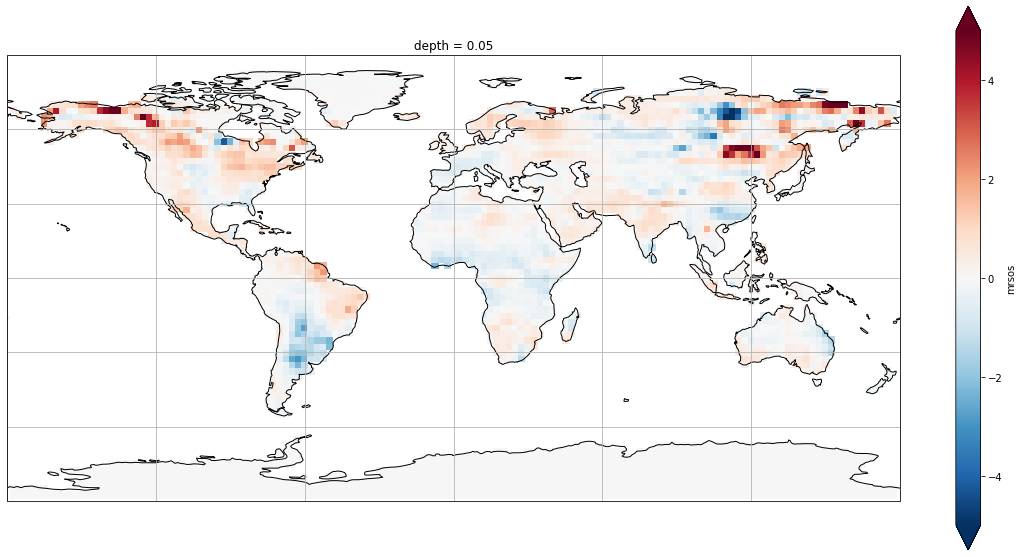

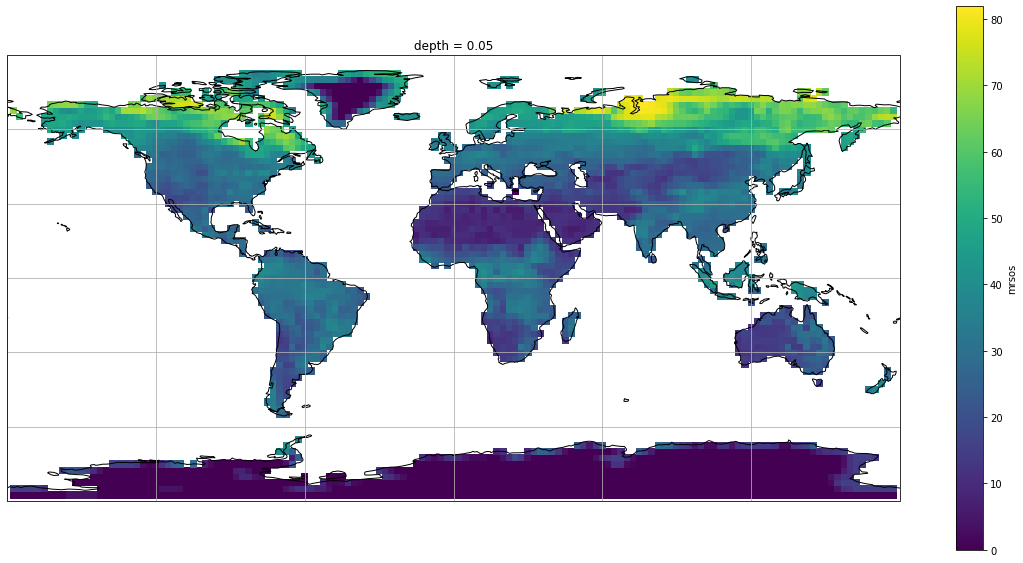

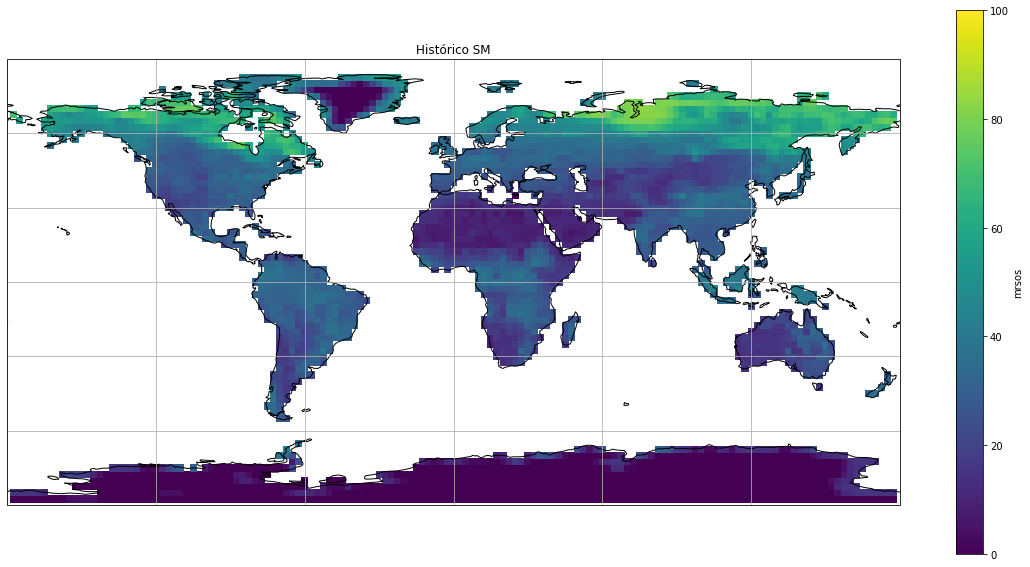

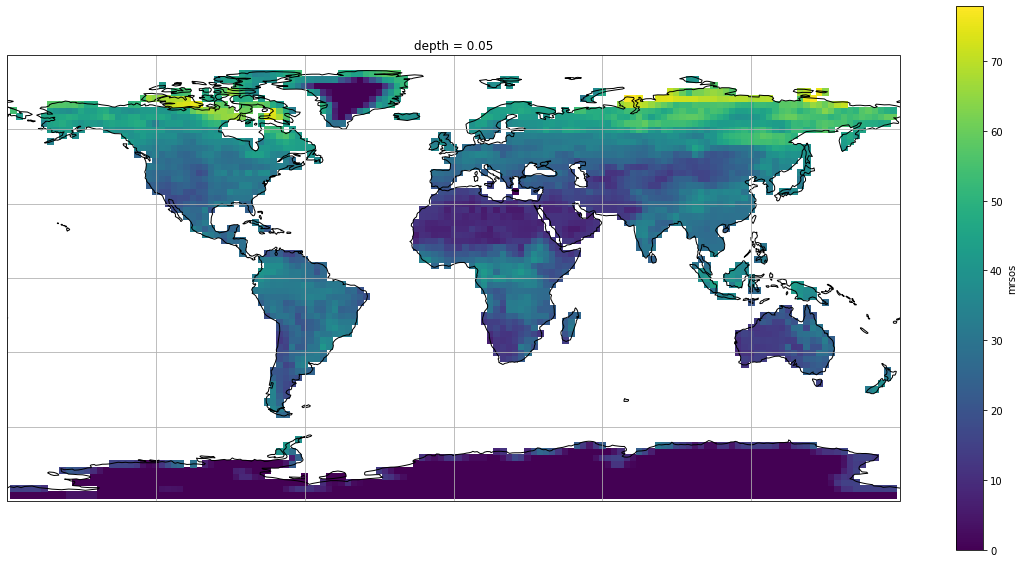

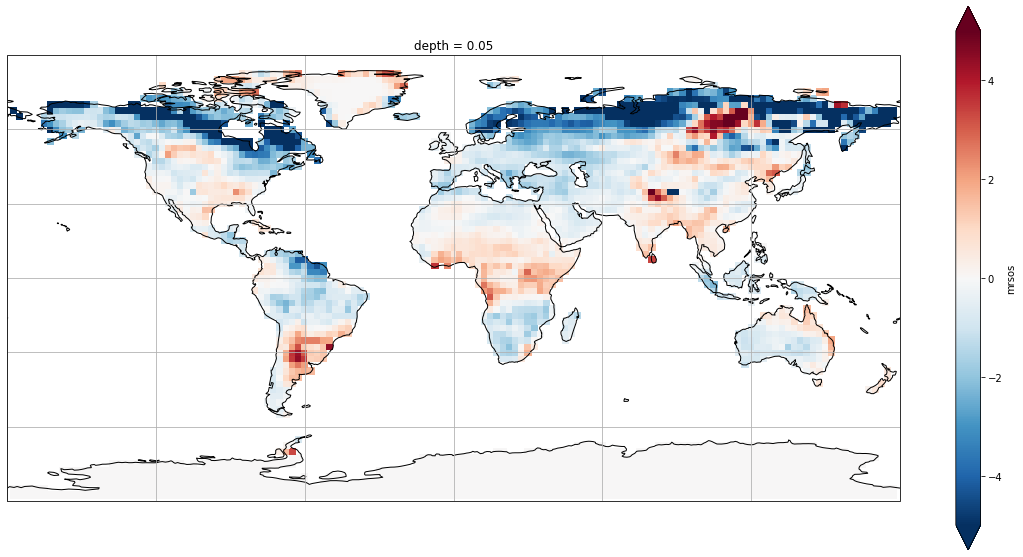

In [7]:
mask_land = regionmask.defined_regions.natural_earth.land_110.mask(sm_thin_c6_ens)

plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree())
(sm_thin_c6_126_close - sm_thin_c6_585_close).mean(dim='time').where(mask_land == 0).plot(vmax=5)
ax.coastlines()
ax.gridlines()
plt.show()
plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree())
sm_thin_c6_585_close.mean(dim='time').where(mask_land == 0).plot()
ax.coastlines()
ax.gridlines()

plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree())
sm_thin_c6_ens.mean(dim='time').where(mask_land == 0).plot(vmax = 100)
ax.coastlines()
ax.gridlines()
plt.title('Histórico SM')
plt.show()
plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree())
sm_thin_c6_585_far.mean(dim='time').where(mask_land == 0).plot()
ax.coastlines()
ax.gridlines()

plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree())
(sm_thin_c6_585_far.mean(dim='time') - sm_thin_c6_126_far.mean(dim='time')).where(mask_land == 0).plot(vmax=5)
ax.coastlines()
ax.gridlines()
plt.show()


<xarray.DataArray 'SoilMoi0_10cm_inst' (time: 360, lat: 32, lon: 35)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       ...,

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]])
Coordinates:
  * time     (time) datetime64[ns] 1976-01-01 1976-02-01 ... 2005-12-01
  * lat      (lat) float64 -58.5 -56.0 -53.5 -51.0 -48.5 ... 11.5 14.0 16.5 19.0
  * lon      (lon) float64 247.5 250.0 252.5 255.0 ... 325.0 327.5 330.0 332.5
Attributes:
    standard_name:  soil_moisture_content
    long_name:      Soil moisture
    units:          kg m-2
    cell_methods:   time: mean
    vmin:           2.0
    vmax:           100.0

<xarray.DataArray 'mrsos' (time: 360, lat: 73, lon: 144)>
dask.array<mean_agg-aggregate, shape=(360, 73, 144), dtype=float32, chunksize=(360, 73, 144), chunktype=numpy.ndarray>
Coordinates:
    depth    float64 0.05
  * time     (time) object 1976-01-16 12:00:00 ... 2005-12-16 12:00:00
  * lat      (lat) float64 -90.0 -87.5 -85.0 -82.5 -80.0 ... 82.5 85.0 87.5 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    standard_name:   mass_content_of_water_in_soil_layer
    long_name:       Moisture in Upper Portion of Soil Column
    units:           kg m-2
    comment:         The mass of water in all phases in the upper 10cm of the...
    original_name:   SOILWATER_10CM
    original_units:  kg/m2
    history:         2019-09-17T21:18:32Z altered by CMOR: Converted units fr...
    cell_methods:    area: mean where land time: mean

/home/tobi/programs/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


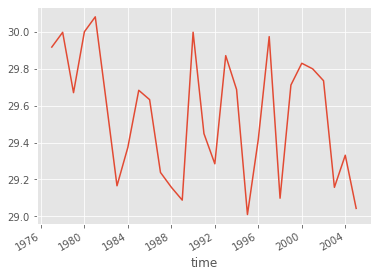

/home/tobi/programs/anaconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/tobi/programs/anaconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/tobi/programs/anaconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/tobi/programs/anaconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


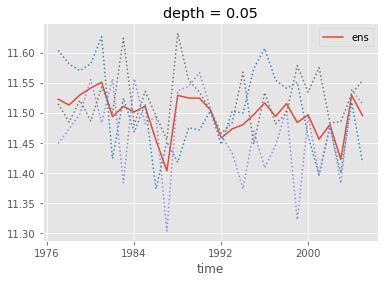

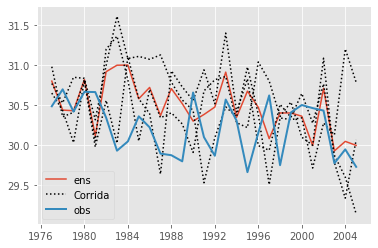

In [104]:
#plt.figure(figsize=(20,10))
#display(np.isfinite(sm_thin_obs.isel(time=0)))
#display(np.isfinite(sm_thin_c6_585_far))
#sm_thin_c6_585_far.mean(dim='time').where(np.isfinite(sm_thin_obs.isel(time=0))).plot()
#plt.show()
def regrid_lat(xarray, min_lat=-90, max_lat=90, step=2.5):
    """Lleva a una grilla con los puntos entre 2 puntos
    adyacentes de la original que tenemos"""
    new_grid_lat = np.arange(min_lat, max_lat, step)
    return xarray.interp(lat=new_grid_lat)


# ax=plt.axes(projection=ccrs.PlateCarree())
# sm_thin_obs_regrid = regrid_lat(sm_thin_obs, -57.5, 20)
# sm_thin_obs.mean(dim='time').plot()
# ax.coastlines()
# plt.show()
# ax=plt.axes(projection=ccrs.PlateCarree())
# sm_thin_obs_regrid.mean(dim='time').plot()
# ax.coastlines()
# plt.show()
# 
# ax=plt.axes(projection=ccrs.PlateCarree())
# sm_thin_c6_ens.mean(dim='time').where(np.isfinite(sm_thin_obs_regrid.isel(time=0))).plot()
# ax.coastlines()
# plt.show()
# 
# #
# ax=plt.axes(projection=ccrs.PlateCarree())
# (sm_thin_c6_ens.mean(dim='time') - sm_thin_obs_regrid.mean(dim='time')).where(
#     np.isfinite(sm_thin_obs_regrid.isel(time=0))).plot()
# ax.coastlines()
# plt.show()
# 
# ax=plt.axes(projection=ccrs.PlateCarree())
# (sm_thin_c5_ens.mean(dim='time') - sm_thin_obs_regrid.mean(dim='time')).where(
#     np.isfinite(sm_thin_obs_regrid.isel(time=0))).plot()
# ax.coastlines()
# plt.show()
# 
# ax=plt.axes(projection=ccrs.PlateCarree())
# (sm_thin_c6_ens.mean(dim='time') - sm_thin_c5_ens.mean(dim='time')).where(
#     np.isfinite(sm_thin_obs_regrid.isel(time=0))).plot()
# ax.coastlines()
# plt.show()


def sel_season(da, center_month, len_season=3):
    da_rav = da.rolling(time=len_season, center=True).mean()
    return da_rav.sel(time = da_rav['time.month']==center_month)

display(sm_thin_obs)
display(sm_thin_c6_ens)

with plt.style.context('ggplot'):
            
    plt.plot(sel_season(sm_thin_obs, 1).time, sel_season(sm_thin_c6_ens, 1).where(
        np.isfinite(sm_thin_obs_regrid.isel(time=0))).weighted(weights).mean(dim=('lat', 'lon')), label='ens')
    plt.plot(sel_season(sm_thin_obs, 1).time, sel_season(sm_thin_c6_hist.isel(r=0), 1).where(
        np.isfinite(sm_thin_obs_regrid.isel(time=0))).weighted(weights).mean(dim=('lat', 'lon')), label='Corrida', linestyle=':', color='k')
    plt.plot(sel_season(sm_thin_obs, 1).time, sel_season(sm_thin_c6_hist.isel(r=1), 1).where(
        np.isfinite(sm_thin_obs_regrid.isel(time=0))).weighted(weights).mean(dim=('lat', 'lon')), linestyle=':', color='k')
    plt.plot(sel_season(sm_thin_obs, 1).time, sel_season(sm_thin_c6_hist.isel(r=2), 1).where(
        np.isfinite(sm_thin_obs_regrid.isel(time=0))).weighted(weights).mean(dim=('lat', 'lon')), linestyle=':', color='k')
    plt.plot(sel_season(sm_thin_obs, 1).time, sel_season(sm_thin_obs_regrid, 1).weighted(weights).mean(dim=('lat', 'lon')), linewidth=2, label='obs')
    plt.legend()
    plt.show()


/home/tobi/programs/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


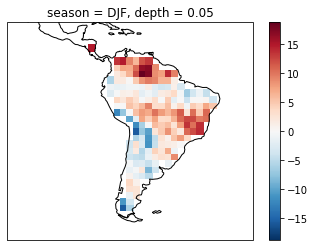

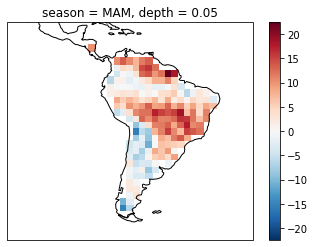

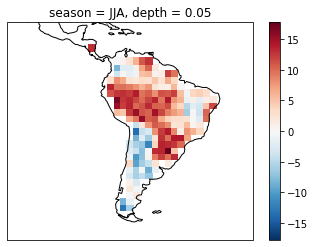

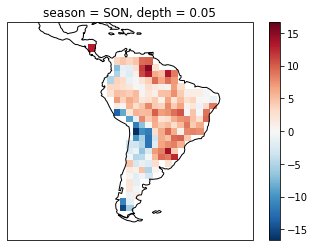

In [9]:
sm_thin_obs_season = sm_thin_obs_regrid.groupby('time.season').mean()
sm_thin_c5_ens_season = sm_thin_c5_ens.groupby('time.season').mean()
sm_thin_c6_ens_season = sm_thin_c6_ens.groupby('time.season').mean()
#display(sm_thin_obs_season)
#sm_thin_obs_season.sel(season='DJF').plot()
#plt.show()
#sm_thin_obs_season.sel(season='MAM').plot()
#plt.show()
#sm_thin_obs_season.sel(season='JJA').plot()
#plt.show()
#sm_thin_obs_season.sel(season='SON').plot()
#plt.show()
ax=plt.axes(projection=ccrs.PlateCarree())
(sm_thin_obs_season.sel(season='DJF') - (sm_thin_c5_ens_season.where(sm_thin_obs_season).sel(season='DJF'))).plot()
ax.coastlines()
plt.show()

ax=plt.axes(projection=ccrs.PlateCarree())
(sm_thin_obs_season.sel(season='MAM') - sm_thin_c5_ens_season.where(sm_thin_obs_season).sel(season='MAM')).plot()
ax.coastlines()
plt.show()

ax=plt.axes(projection=ccrs.PlateCarree())
(sm_thin_obs_season.sel(season='JJA') - sm_thin_c5_ens_season.where(sm_thin_obs_season).sel(season='JJA')).plot()
ax.coastlines()
plt.show()

ax=plt.axes(projection=ccrs.PlateCarree())
(sm_thin_obs_season.sel(season='SON') - sm_thin_c5_ens_season.where(sm_thin_obs_season).sel(season='SON')).plot()
ax.coastlines()
plt.show()
#sm_thin_c5_ens_season.where(np.isfinite(sm_thin_obs_season)).sel(season='DJF').plot()


/home/tobi/programs/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


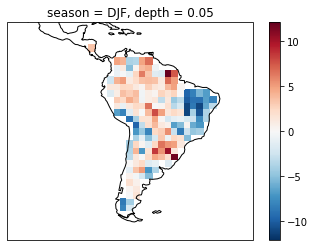

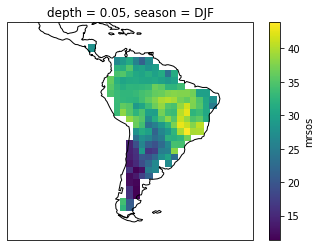

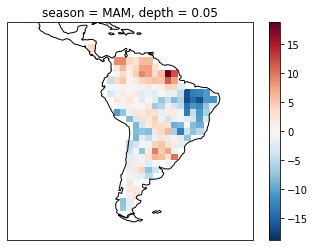

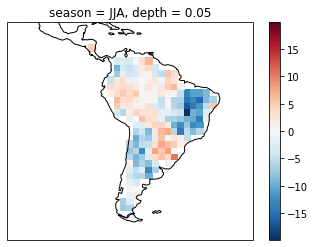

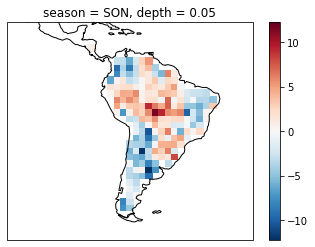

In [10]:
sm_thin_obs_season = sm_thin_obs_regrid.groupby('time.season').mean()
sm_thin_c5_ens_season = sm_thin_c5_ens.groupby('time.season').mean()
sm_thin_c6_ens_season = sm_thin_c6_ens.groupby('time.season').mean()
#display(sm_thin_obs_season)
#sm_thin_obs_season.sel(season='DJF').plot()
#plt.show()
#sm_thin_obs_season.sel(season='MAM').plot()
#plt.show()
#sm_thin_obs_season.sel(season='JJA').plot()
#plt.show()
#sm_thin_obs_season.sel(season='SON').plot()
#plt.show()
ax=plt.axes(projection=ccrs.PlateCarree())
(sm_thin_obs_season.sel(season='DJF') - (sm_thin_c6_ens_season.where(sm_thin_obs_season).sel(season='DJF'))).plot()
ax.coastlines()
plt.show()

ax=plt.axes(projection=ccrs.PlateCarree())
((sm_thin_c6_ens_season.where(np.isfinite(sm_thin_obs_season)).sel(season='DJF'))).plot()
ax.coastlines()
plt.show()

ax=plt.axes(projection=ccrs.PlateCarree())
(sm_thin_obs_season.sel(season='MAM') - sm_thin_c6_ens_season.where(sm_thin_obs_season).sel(season='MAM')).plot()
ax.coastlines()
plt.show()

ax=plt.axes(projection=ccrs.PlateCarree())
(sm_thin_obs_season.sel(season='JJA') - sm_thin_c6_ens_season.where(sm_thin_obs_season).sel(season='JJA')).plot()
ax.coastlines()
plt.show()

ax=plt.axes(projection=ccrs.PlateCarree())
(sm_thin_obs_season.sel(season='SON') - sm_thin_c6_ens_season.where(sm_thin_obs_season).sel(season='SON')).plot()
ax.coastlines()
plt.show()
#sm_thin_c5_ens_season.where(np.isfinite(sm_thin_obs_season)).sel(season='DJF').plot()


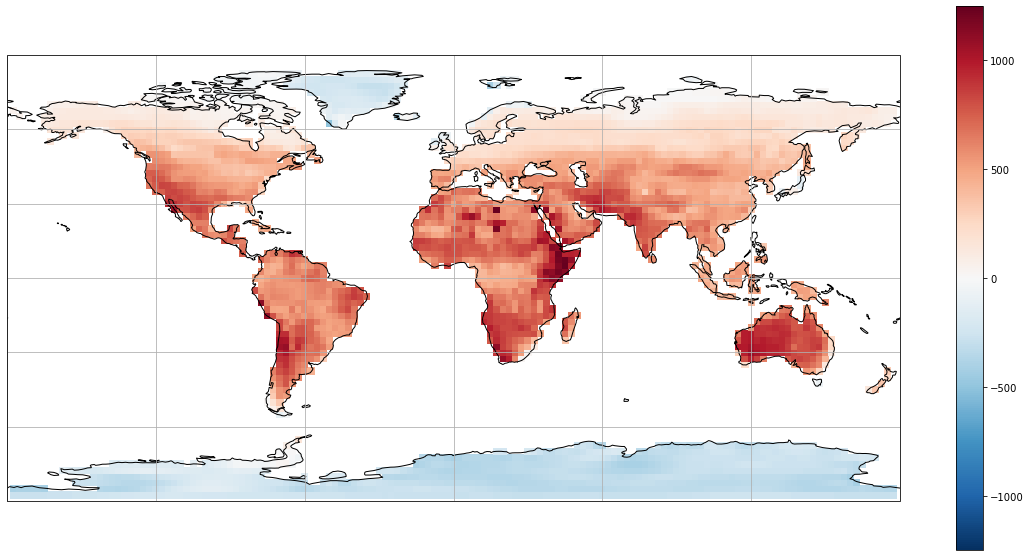

<xarray.DataArray 'mrsos' (time: 360, lat: 73, lon: 144)>
dask.array<mean_agg-aggregate, shape=(360, 73, 144), dtype=float32, chunksize=(360, 73, 144), chunktype=numpy.ndarray>
Coordinates:
    depth    float64 0.05
  * time     (time) object 1976-01-16 12:00:00 ... 2005-12-16 12:00:00
  * lat      (lat) float64 -90.0 -87.5 -85.0 -82.5 -80.0 ... 82.5 85.0 87.5 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    standard_name:   mass_content_of_water_in_soil_layer
    long_name:       Moisture in Upper Portion of Soil Column
    units:           kg m-2
    comment:         The mass of water in all phases in the upper 10cm of the...
    original_name:   SOILWATER_10CM
    original_units:  kg/m2
    history:         2019-09-17T21:18:32Z altered by CMOR: Converted units fr...
    cell_methods:    area: mean where land time: mean

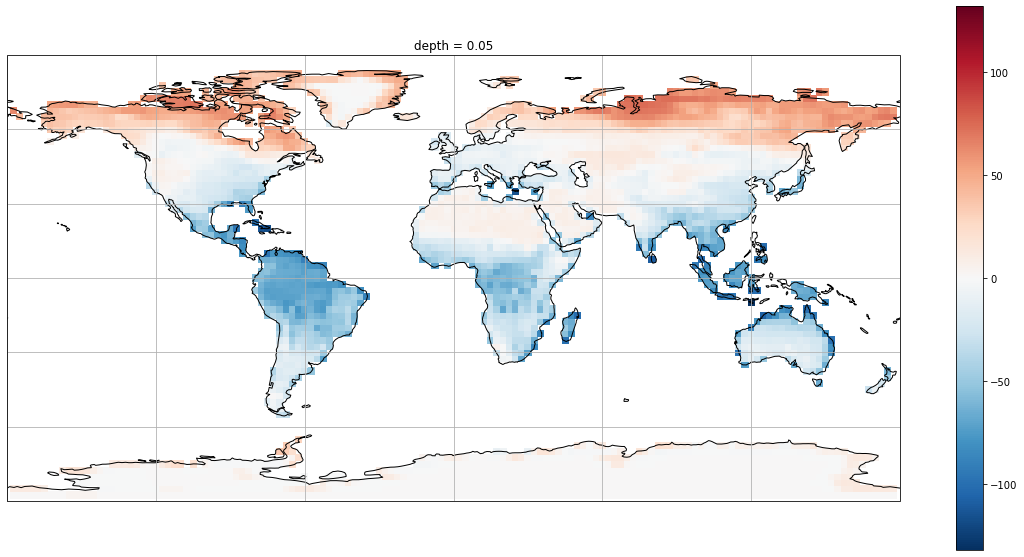

In [11]:
dif_ep_e_hist = ep_c6_ens - ev_c6_ens

plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree())
dif_ep_e_hist.mean(dim='time').where(mask_land == 0).plot()
ax.coastlines()
ax.gridlines()
plt.show()

dif_sm_thin_e_hist = sm_thin_c6_ens - mes_ev_c6_ens
display(sm_thin_c6_ens)

plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree())
dif_sm_thin_e_hist.mean(dim='time').where(mask_land == 0).plot()
ax.coastlines()
ax.gridlines()
plt.show()

/home/tobi/programs/anaconda3/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


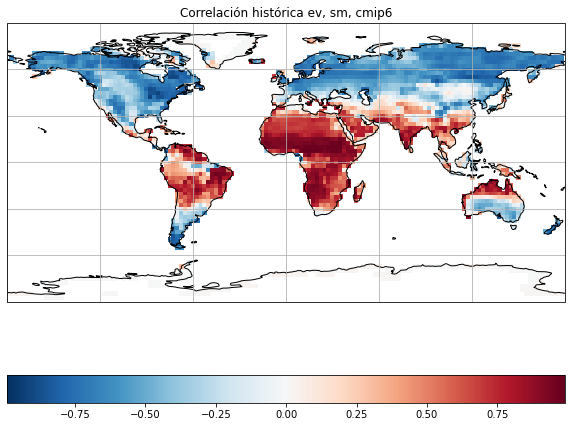

In [12]:
corr_e_sm = correlation(mes_ev_c6_ens, sm_thin_c6_ens, dim='time')

plt.figure(figsize=(10,9))
ax = plt.axes(projection=ccrs.PlateCarree())
corr_e_sm.where(mask_land == 0).plot(cbar_kwargs={'orientation':'horizontal'})
plt.title('Correlación histórica ev, sm, cmip6')
ax.coastlines()
ax.gridlines()
plt.show()

/home/tobi/programs/anaconda3/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


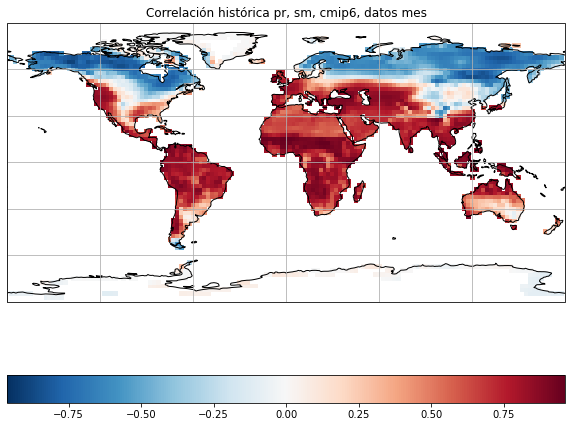

/home/tobi/programs/anaconda3/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


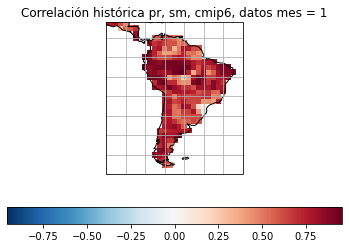

/home/tobi/programs/anaconda3/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


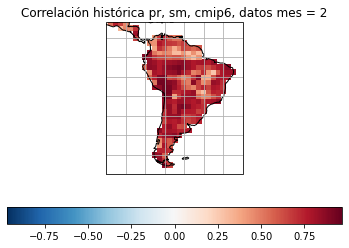

/home/tobi/programs/anaconda3/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


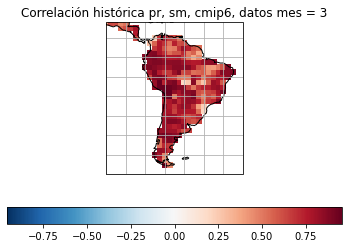

/home/tobi/programs/anaconda3/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


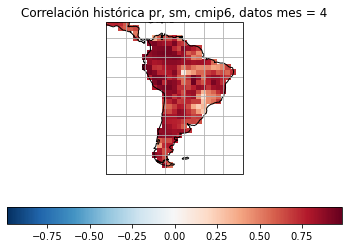

/home/tobi/programs/anaconda3/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


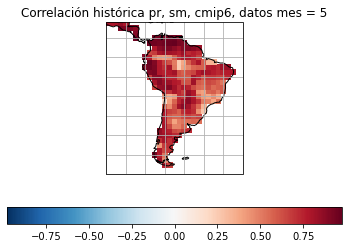

/home/tobi/programs/anaconda3/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


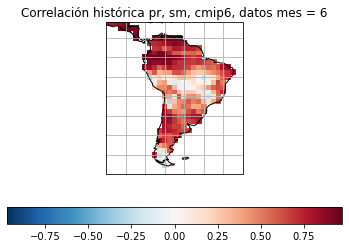

/home/tobi/programs/anaconda3/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


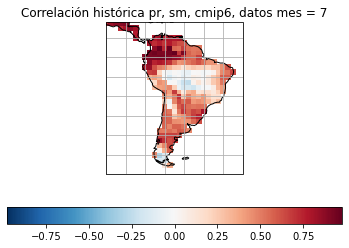

/home/tobi/programs/anaconda3/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


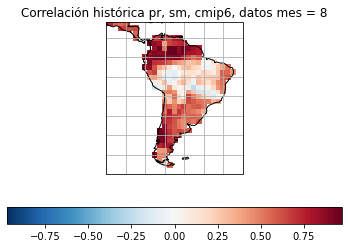

/home/tobi/programs/anaconda3/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


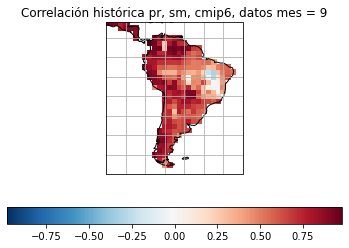

/home/tobi/programs/anaconda3/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


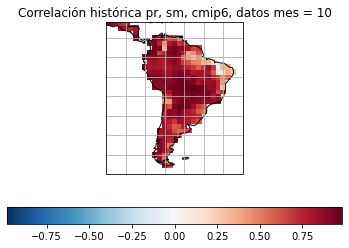

/home/tobi/programs/anaconda3/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


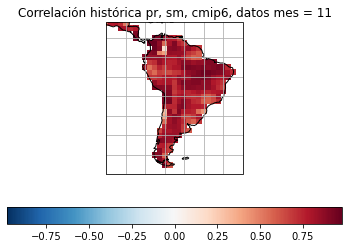

/home/tobi/programs/anaconda3/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


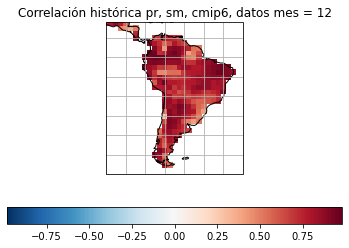

In [51]:
corr_p_sm = correlation(mes_pr_c6_ens, sm_thin_c6_ens, dim='time')

plt.figure(figsize=(10,9))
ax = plt.axes(projection=ccrs.PlateCarree())
corr_p_sm.where(mask_land == 0).plot(cbar_kwargs={'orientation':'horizontal'})
plt.title('Correlación histórica pr, sm, cmip6, datos mes')
ax.coastlines()
ax.gridlines()
plt.show()


for month in range(1,13):
    corr_p_sm = correlation(mes_pr_c6_ens.sel(time = mes_pr_c6_ens['time.month']==month),
                            sm_thin_c6_ens.sel(time = sm_thin_c6_ens['time.month']==month),
                            dim='time')
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([260, 330, -55, 15])
    corr_p_sm.where(mask_land == 0).plot(cbar_kwargs={'orientation':'horizontal'})
    plt.title('Correlación histórica pr, sm, cmip6, datos mes = ' + str(month))
    ax.coastlines()
    ax.gridlines()
    plt.show()

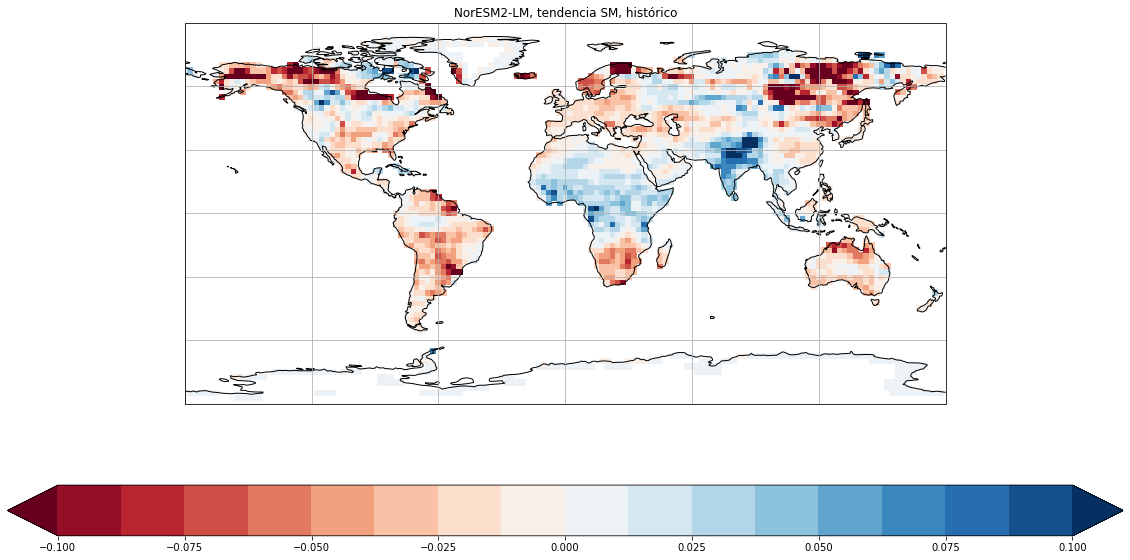

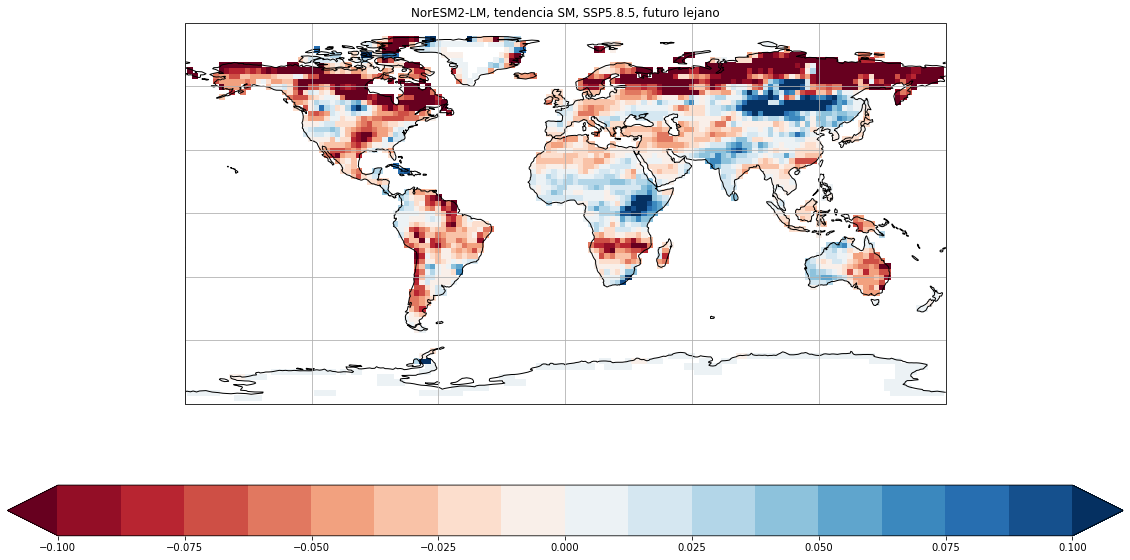

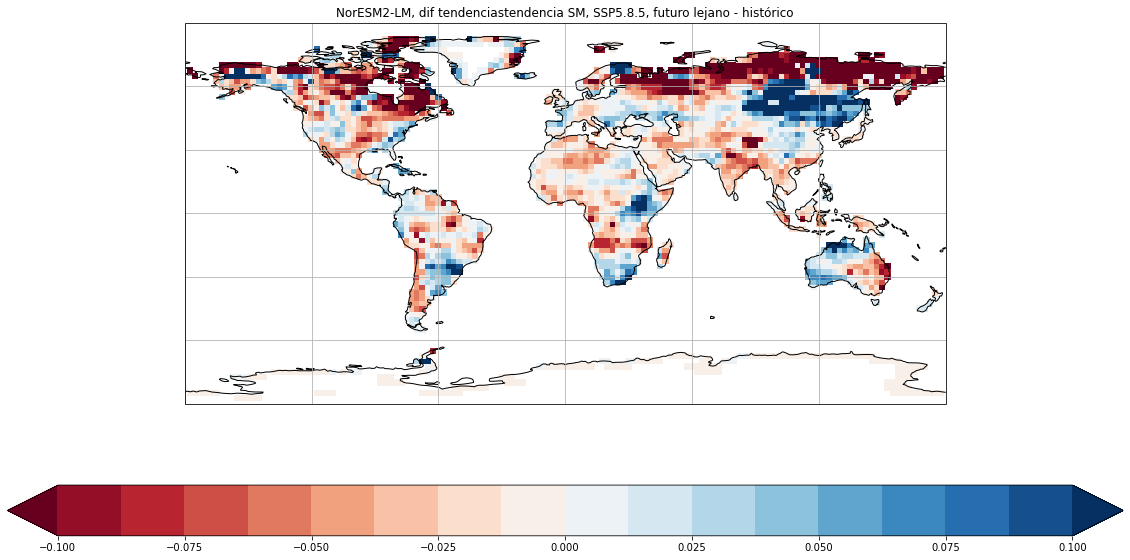

In [14]:
sm_thin_c6_ens_trend = xr_trends(sm_thin_c6_ens)

plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree())
sm_thin_c6_ens_trend.where(mask_land == 0).where(sm_thin_c6_ens_trend != 0).plot(
    vmin=-0.1, levels=17, cbar_kwargs={'orientation':'horizontal'}, cmap='RdBu')
ax.gridlines()
ax.coastlines()
plt.title('NorESM2-LM, tendencia SM, histórico')
plt.show()

sm_thin_c6_585_far_trend = xr_trends(sm_thin_c6_585_far)

plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree())
sm_thin_c6_585_far_trend.where(mask_land == 0).where(sm_thin_c6_ens_trend != 0).plot(
    vmin=-0.1, levels=17, cbar_kwargs={'orientation':'horizontal'}, cmap='RdBu')
ax.gridlines()
ax.coastlines()
plt.title('NorESM2-LM, tendencia SM, SSP5.8.5, futuro lejano')
plt.show()

plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree())
(sm_thin_c6_585_far_trend - sm_thin_c6_ens_trend).where(
    mask_land == 0).where(sm_thin_c6_ens_trend != 0).plot(vmin=-0.1, levels=17, cbar_kwargs={'orientation':'horizontal'}, cmap='RdBu')
ax.gridlines()
ax.coastlines()
plt.title('NorESM2-LM, dif tendenciastendencia SM, SSP5.8.5, futuro lejano - histórico')
plt.show()


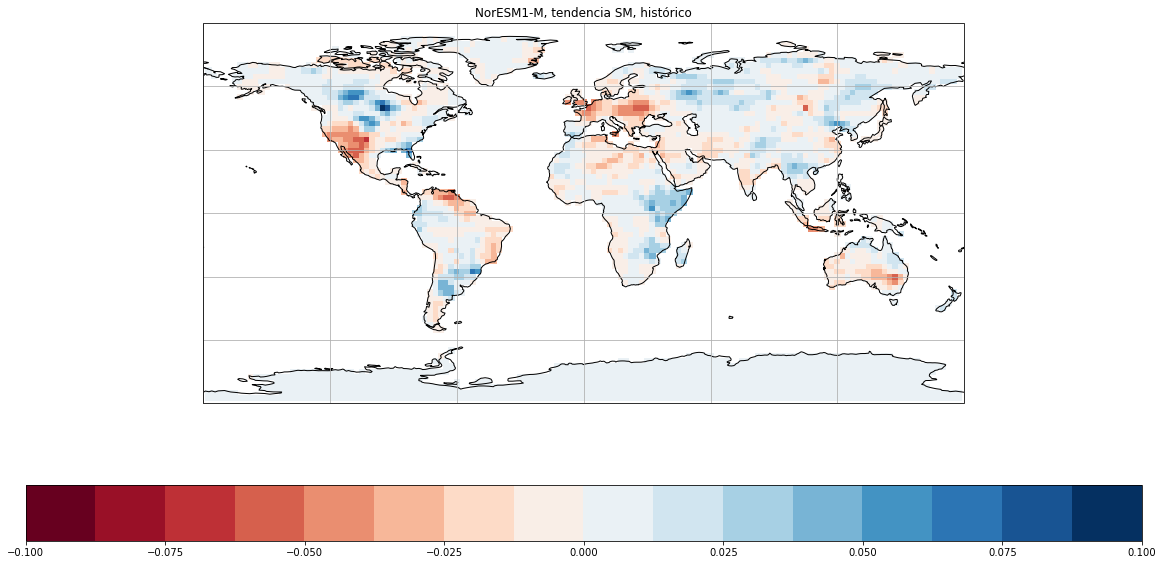

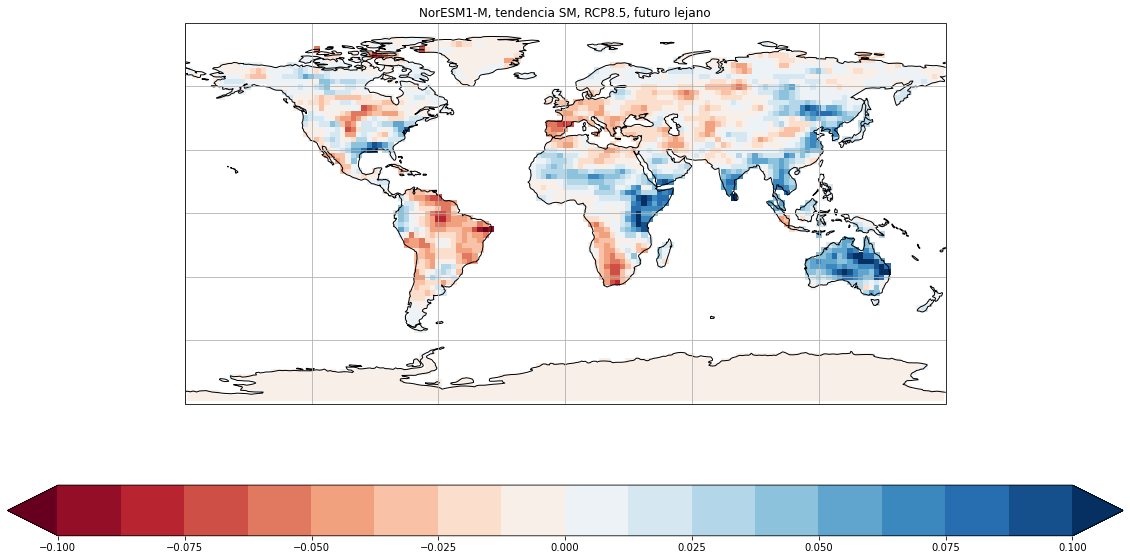

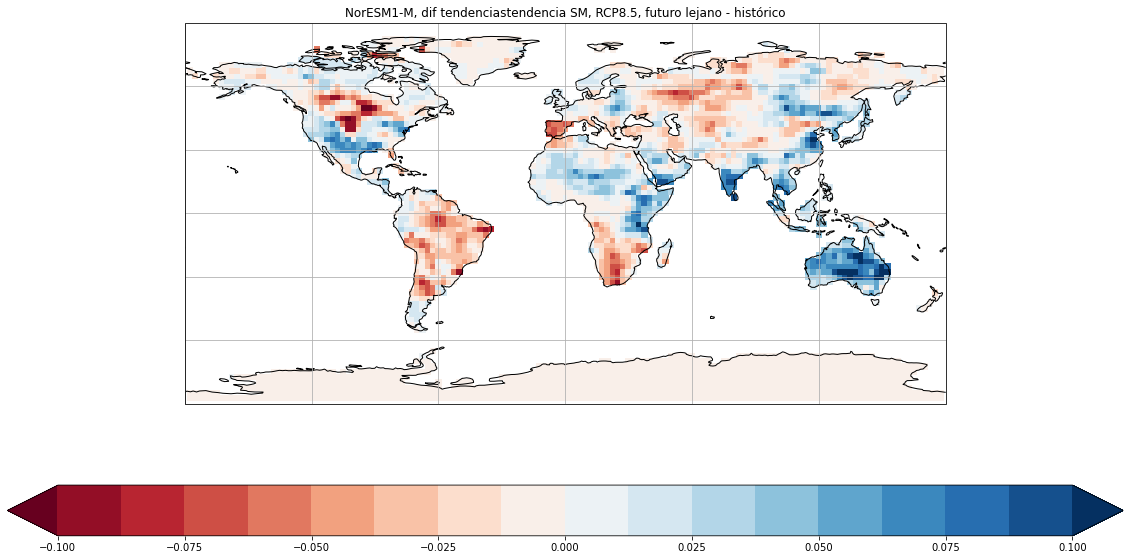

In [15]:
sm_thin_c5_ens_trend = xr_trends(sm_thin_c5_ens)

plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree())
sm_thin_c5_ens_trend.where(mask_land == 0).where(sm_thin_c5_ens_trend != 0).plot(
    vmin=-0.1, levels=17, cbar_kwargs={'orientation':'horizontal'}, cmap='RdBu')
ax.gridlines()
ax.coastlines()
plt.title('NorESM1-M, tendencia SM, histórico')
plt.show()

sm_thin_c5_85_far_trend = xr_trends(sm_thin_c5_85_far)

plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree())
sm_thin_c5_85_far_trend.where(mask_land == 0).where(sm_thin_c5_ens_trend != 0).plot(
    vmin=-0.1, levels=17, cbar_kwargs={'orientation':'horizontal'}, cmap='RdBu')
ax.gridlines()
ax.coastlines()
plt.title('NorESM1-M, tendencia SM, RCP8.5, futuro lejano')
plt.show()

plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree())
(sm_thin_c5_85_far_trend - sm_thin_c5_ens_trend).where(
    mask_land == 0).where(sm_thin_c5_ens_trend != 0).plot(
    vmin=-0.1, levels=17, cbar_kwargs={'orientation':'horizontal'}, cmap='RdBu')
ax.gridlines()
ax.coastlines()
plt.title('NorESM1-M, dif tendenciastendencia SM, RCP8.5, futuro lejano - histórico')
plt.show()


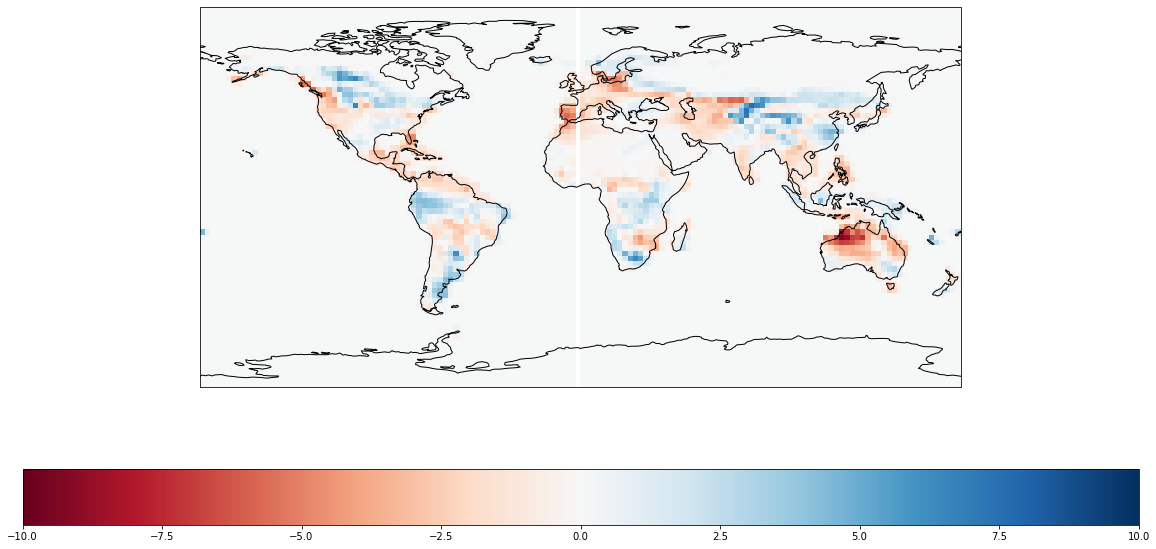

In [16]:
#sm_thin_c6_runoff_ens = sm_thin_c6_ens.isel(time=slice(0,359))
#for i in range(0, len(sm_thin_c6_runoff_ens)):
#    sm_thin_c6_runoff_ens[i] = sm_thin_c6_ens.isel(time=i+1) - sm_thin_c6_ens.isel(time=i)
#display(sm_thin_c6_runoff_ens)
plt.figure(figsize=(20,10))
sm_thin_c6_acc = sm_thin_c6_ens.isel(time=2).values - sm_thin_c6_ens.isel(time=1).values
ax = plt.axes(projection=ccrs.PlateCarree())
plt.pcolormesh(sm_thin_c6_ens.lon.values, sm_thin_c6_ens.lat.values, sm_thin_c6_acc, cmap='RdBu', vmin=-10, vmax=10)
ax.coastlines()
plt.colorbar(orientation='horizontal')
#(sm_thin_c6_ens.isel(time=2).values - sm_thin_c6_ens.isel(time=1).values).shape

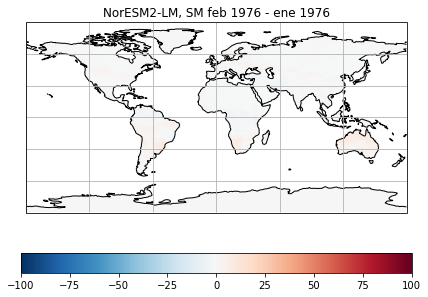

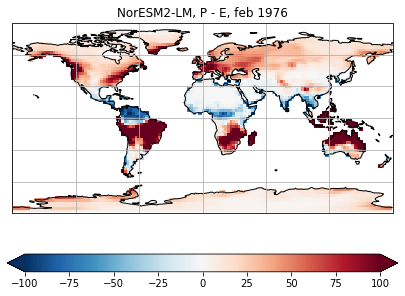

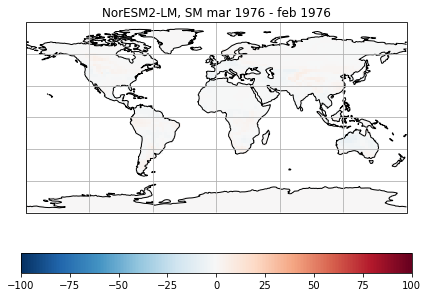

In [17]:
#display((sm_thin_c6_ens.time[1] - sm_thin_c6_ens.time[0])/2)

subs = rolling_sub(sm_thin_c6_ens)
#display(subs)
plt.figure(figsize=(7,5))
ax = plt.axes(projection = ccrs.PlateCarree())
subs[0].where(mask_land == 0).plot(vmax=100, cbar_kwargs={'orientation':'horizontal'})
ax.coastlines()
ax.gridlines()
plt.title('NorESM2-LM, SM feb 1976 - ene 1976')
plt.show()

plt.figure(figsize=(7,5))
ax = plt.axes(projection = ccrs.PlateCarree())
(mes_pr_c6_ens.isel(time=1) - mes_ev_c6_ens.isel(time=1)).where(
    mask_land == 0).plot(vmax=100, cbar_kwargs={'orientation':'horizontal'})
ax.coastlines()
ax.gridlines()
plt.title('NorESM2-LM, P - E, feb 1976')
plt.show()

subs = rolling_sub(sm_thin_c6_ens)
#display(subs)
plt.figure(figsize=(7,5))
ax = plt.axes(projection = ccrs.PlateCarree())
subs[1].where(mask_land == 0).plot(vmax=100, cbar_kwargs={'orientation':'horizontal'})
ax.coastlines()
ax.gridlines()
plt.title('NorESM2-LM, SM mar 1976 - feb 1976')
plt.show()


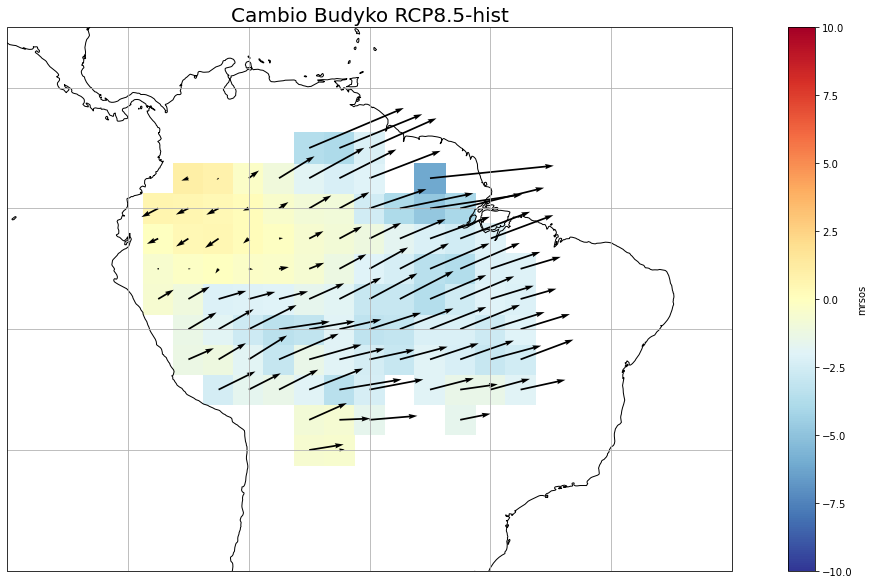

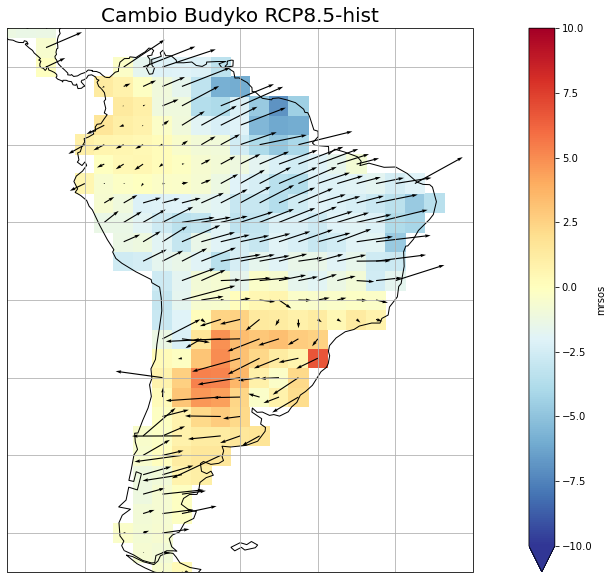

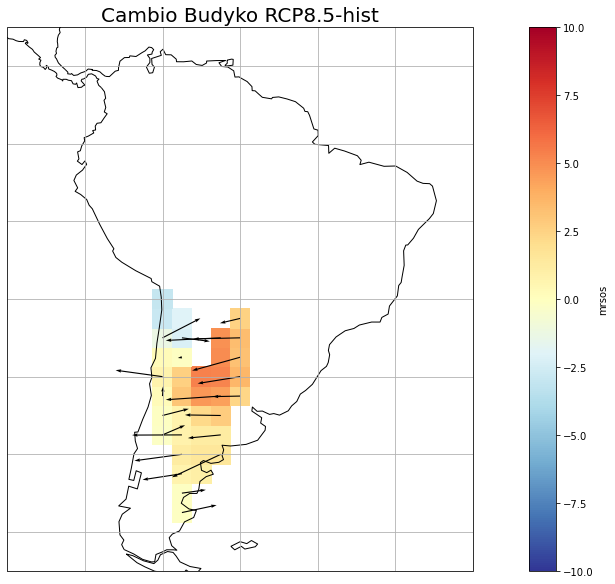

In [18]:
u = (ep_c6_585_far.mean(dim='time') / pr_c6_585_far.mean(dim='time')) - (
     ep_c6_ens.mean(dim='time') / pr_c6_ens.mean(dim='time'))

regimen_hist = (ep_c6_ens/pr_c6_ens).mean(dim='time')

v = (ev_c6_585_far.mean(dim='time') / pr_c6_585_far.mean(dim='time')) - (
     ev_c6_ens.mean(dim='time') / pr_c6_ens.mean(dim='time'))

mod = np.sqrt(u*u + v*v)

sm_thin_change = sm_thin_c6_585_far.mean(dim='time') - sm_thin_c6_ens.mean(dim='time')

plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([270, 330, 15, -30], crs=ccrs.PlateCarree())
sm_thin_change.where(amazon_mask == 1).plot(cmap='RdYlBu_r', vmax=10)
ax.coastlines()
ax.gridlines()
ax.quiver(u.lon.values, u.lat.values, u.where(amazon_mask == 1), v.where(amazon_mask == 1), scale=4)
plt.title('Cambio Budyko RCP8.5-hist', fontsize=20)
plt.show()

plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([270, 330, 15, -55], crs=ccrs.PlateCarree())
sm_thin_change.where(mask_land==0).plot(cmap='RdYlBu_r', vmax=10)
ax.coastlines()
ax.gridlines()
ax.quiver(u.lon.values, u.lat.values, u.where(mask_land == 0).where(mod<0.5),
          v.where(mask_land == 0).where(mod<0.5), scale=4)
plt.title('Cambio Budyko RCP8.5-hist', fontsize=20)
plt.show()

plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([270, 330, 15, -55], crs=ccrs.PlateCarree())
sm_thin_change.where(mask_land==0).where(
    regimen_hist > 2).plot(
        cmap='RdYlBu_r', vmax=10)
ax.coastlines()
ax.gridlines()
ax.quiver(u.lon.values, u.lat.values, u.where(mask_land == 0).where(mod<0.5).where(regimen_hist > 2),
          v.where(mask_land == 0).where(mod<0.5).where(regimen_hist > 2), scale=4)
plt.title('Cambio Budyko RCP8.5-hist', fontsize=20)
plt.show()

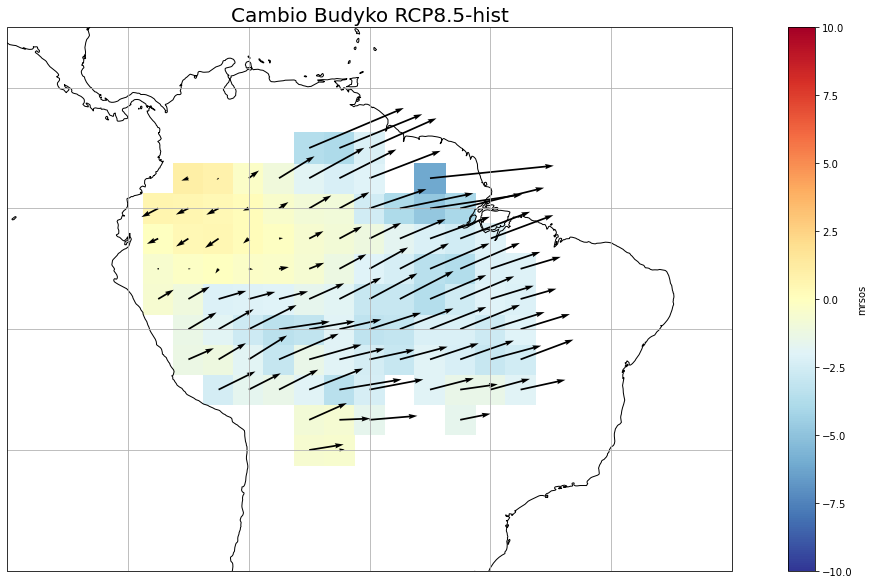

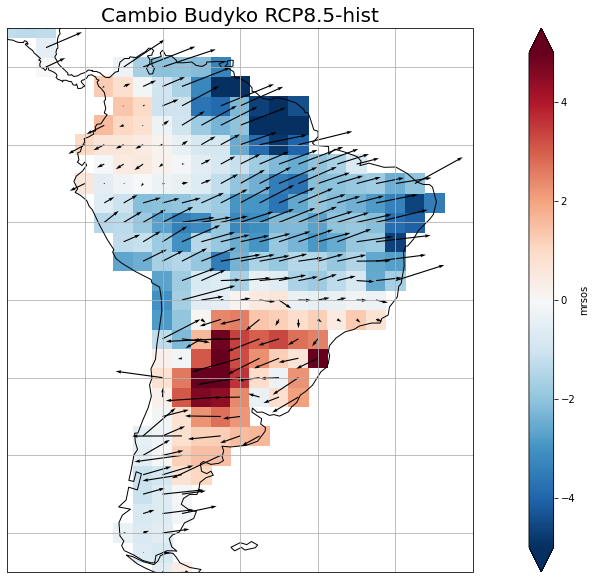

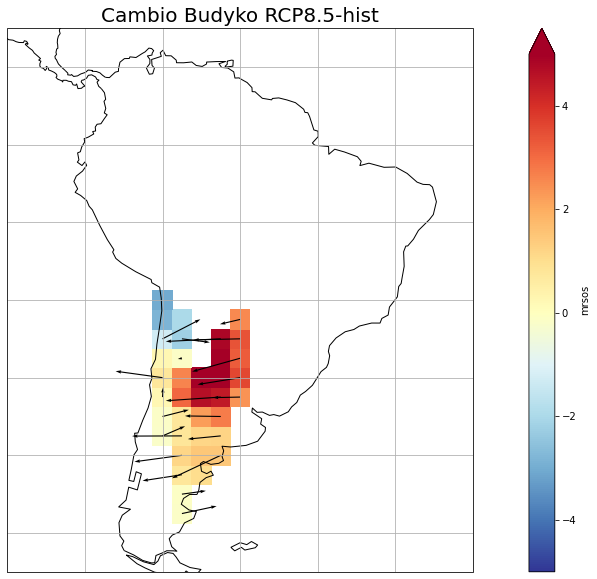

In [19]:
u = (ep_c6_585_far.mean(dim='time') / pr_c6_585_far.mean(dim='time')) - (
     ep_c6_ens.mean(dim='time') / pr_c6_ens.mean(dim='time'))

regimen_hist = (ep_c6_ens/pr_c6_ens).mean(dim='time')

v = (ev_c6_585_far.mean(dim='time') / pr_c6_585_far.mean(dim='time')) - (
     ev_c6_ens.mean(dim='time') / pr_c6_ens.mean(dim='time'))

mod = np.sqrt(u*u + v*v)

sm_thin_change = sm_thin_c6_585_far.mean(dim='time') - sm_thin_c6_ens.mean(dim='time')

plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([270, 330, 15, -30], crs=ccrs.PlateCarree())
sm_thin_change.where(amazon_mask == 1).plot(cmap='RdYlBu_r', vmax=10)
ax.coastlines()
ax.gridlines()
ax.quiver(u.lon.values, u.lat.values, u.where(amazon_mask == 1), v.where(amazon_mask == 1), scale=4)
plt.title('Cambio Budyko RCP8.5-hist', fontsize=20)
plt.show()

plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([270, 330, 15, -55], crs=ccrs.PlateCarree())
sm_thin_change.where(mask_land==0).plot(cmap='RdBu_r', vmax=5)
ax.coastlines()
ax.gridlines()
ax.quiver(u.lon.values, u.lat.values, u.where(mask_land == 0).where(mod<0.5),
          v.where(mask_land == 0).where(mod<0.5), scale=4)
plt.title('Cambio Budyko RCP8.5-hist', fontsize=20)
plt.show()

plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([270, 330, 15, -55], crs=ccrs.PlateCarree())
sm_thin_change.where(mask_land==0).where(
    regimen_hist > 2).plot(
        cmap='RdYlBu_r', vmax=5)
ax.coastlines()
ax.gridlines()
ax.quiver(u.lon.values, u.lat.values, u.where(mask_land == 0).where(mod<0.5).where(regimen_hist > 2),
          v.where(mask_land == 0).where(mod<0.5).where(regimen_hist > 2), scale=4)
plt.title('Cambio Budyko RCP8.5-hist', fontsize=20)
plt.show()

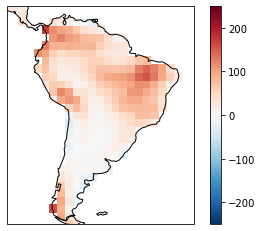

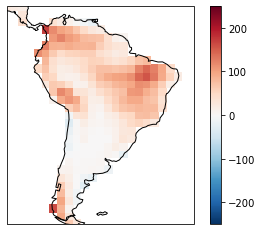

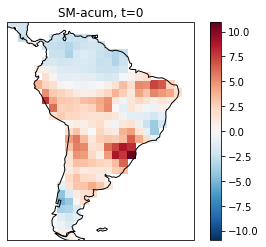

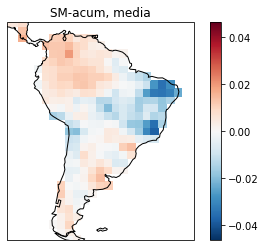

In [20]:
p_ev_c6_ens = mes_pr_c6_ens - mes_ev_c6_ens

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([270, 330, 15, -55], crs=ccrs.PlateCarree())
p_ev_c6_ens.mean(dim='time').where(mask_land == 0).plot()#cbar_kwargs={'orientation':'horizontal'})
ax.coastlines()
plt.show()

sm_thin_acc = rolling_sub(sm_thin_c6_ens)
runoff =  p_ev_c6_ens.isel(time=slice(1, len(p_ev_c6_ens))) - sm_thin_acc 
#display(sm_thin_acc)
#display(ep_p_c6_ens.isel(time=slice(1, len(ep_p_c6_ens))))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([270, 330, 15, -55], crs=ccrs.PlateCarree())
runoff.mean(dim='time').where(mask_land == 0).plot()#cbar_kwargs={'orientation':'horizontal'})
ax.coastlines()
plt.show()

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([270, 330, 15, -55], crs=ccrs.PlateCarree())
sm_thin_acc.isel(time=0).where(mask_land == 0).plot()#cbar_kwargs={'orientation':'horizontal'})
ax.coastlines()
plt.title('SM-acum, t=0')
plt.show()

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([270, 330, 15, -55], crs=ccrs.PlateCarree())
sm_thin_acc.mean(dim='time').where(mask_land == 0).plot()#cbar_kwargs={'orientation':'horizontal'})
ax.coastlines()
plt.title('SM-acum, media')
plt.show()